Prova questo [notebook](https://colab.research.google.com/drive/1Lo2ZNgtDrSkUjTYvq8NkgaOoyrWRVFLG?authuser=4#scrollTo=-dUz6T7p3HUa) in Colab con l'account leo.carraro.14@gmail.com



In [1]:
from PIL import Image
import torch
from enum import Enum
import json
import random
import time
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import os
import sys
sys.path.append("..")

In [2]:
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xmzlp9lf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xmzlp9lf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=d85414127bd4fd8349c626b423ee4961d6bd2ecd1ac2b1f78e3a2c51cda98e9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnyhaq_j/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
if not(os.path.exists('sam_vit_h_4b8939.pth') and os.path.isfile('sam_vit_h_4b8939.pth')):
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-06-13 07:07:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.31, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   174MB/s    in 18s     

2024-06-13 07:07:26 (138 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [4]:
from segment_anything import sam_model_registry, SamPredictor

In [15]:
def read_and_convert_yolo_bboxes(file_path, img_shape, desired_labels):
    height, width, _ = img_shape
    bounding_boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            label = int(parts[0])
            if label in desired_labels:
                x_center = float(parts[1])
                y_center = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                x_min = int((x_center - w / 2) * width)
                y_min = int((y_center - h / 2) * height)
                box_width = int(w * width)
                box_height = int(h * height)
                x_max = x_min + box_width
                y_max = y_min + box_height
                bounding_boxes.append(
                    [x_min, y_min, x_max, y_max])

    return bounding_boxes


def plot_mask(filename):
    plt.title(f"File: {filename}")
    img = plt.imread(filename)
    min_val = img.min()
    max_val = img.max()
    plt.imshow(img, cmap='gray', vmin=min_val, vmax=max_val)
    plt.show()
    pass


def create_polygon_annotation_file(mask_path, output_path):
    # Read the binary mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure the mask is binary
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Open the output file for writing
    with open(output_path, 'w') as file:
        for contour in contours:
            # Flatten the contour array and convert to a list of points
            contour = contour.flatten().tolist()

            # Convert the list of points to a space-separated string
            annotation = ' '.join(map(str, contour))

            # Write the annotation to the file
            file.write(annotation + '\n')


def plot_bboxes(image_path, label_path, desired_labels):
    """Plot bounding boxes on the image and display the result."""
    # Load image
    image = cv2.imread(image_path)
    # Load YOLO labels
    bboxes = read_and_convert_yolo_bboxes(
        label_path, image.shape, desired_labels)

    # Plot image using Matplotlib
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw bounding boxes
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='g', facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)

    # Show the plot
    plt.show()

Suppose we have the following *predictor* oject:
```
predictor = SamPredictor(sam)
```
that has created an embedding for a given image *img* (which is a numpy 2D array)
```
predictor.set_image(img)
```
Suppose that the content of the variable *input_points* is
```
[[656,  69], [592, 157]]
```
and the content of the variable *input_labels* is
```
[1, 0]
```
i.e. there are two points, one that will be placed inside and one that will be placed outside the predicted mask.

When we call the *predict* funcionality as follows
```
masks, scores, logits = predictor.predict(
                    point_coords=np.array(input_points),
                    point_labels=np.array(input_labels),
                    multimask_output=True
                )
```
* The content of the variable *masks* is

```
array([<2D_array boolean mask>,
       <2D_array boolean mask>,
       <2D_array boolean mask>])
```
* The content of the variable *scores* is ...
```
array([0.80286, 0.83264, 0.96942], dtype=float32)
```
In other words *masks[i]* contains a 2D_array boolean mask for the object identified by all positive and negative points with score *scores[i]*

When we call the *predict* funcionality as follows
```
masks, scores, logits = predictor.predict(
                    point_coords=np.array(input_points),
                    point_labels=np.array(input_labels),
                    multimask_output=False
                )
```
* The content of the variable *masks* is:
```
array([<2D_array boolean mask>])
```
* The content of the variable *scores* is:
```
array([0.48542], dtype=float32)
```

Suppose we have the following *predictor* oject:
```
predictor = SamPredictor(sam)
```
that has created an embedding for a given image *img* (which is a numpy 2D array)
```
predictor.set_image(img)
```
Suppose that the content of the variable *transformed_bboxes* is
```
tensor([[656.5926,  69.5072, 720.5926, 146.1232],
        [592.5926, 157.9710, 671.6049, 236.9565]])
```
i.e. it contains two bounding boxes in the form of xyxy coordinates of ul corner and lr corner.

When we call the *predict* funcionality as follows
```
masks, scores, logits = predictor.predict_torch(
                    point_coords=None,
                    point_labels=None,
                    boxes=transformed_bboxes,
                    multimask_output=True
                )
```

* The content of the variable *masks* is

```
tensor([[<2D_array boolean mask for transformed_bboxes[0]>,
         <2D_array boolean mask for transformed_bboxes[0]>,
         <2D_array boolean mask for transformed_bboxes[0]>],
        [<2D_array boolean mask for transformed_bboxes[1]>,
         <2D_array boolean mask for transformed_bboxes[1]>,
         <2D_array boolean mask for transformed_bboxes[1]>]])

```
* The content of the variable *scores* is ...
```
tensor([[0.9746, 0.9801, 0.9747],
        [0.9112, 0.9773, 0.9772]])
```
In other words *masks[i, j]* contains a 2D_array boolean mask for the object predicted with box *transformed_bboxes[i]* with score *scores[j]*

When we call the *predict* funcionality as follows
```
masks, scores, logits = predictor.predict_torch(
                    point_coords=None,
                    point_labels=None,
                    boxes=transformed_bboxes,
                    multimask_output=False
                )
```
The content of the variable *masks* is
```
tensor([<2D_array boolean mask for transformed_bboxes[0]>,
        <2D_array boolean mask for transformed_bboxes[1]>])
```



Suppose we have the following *generator* oject:
```
predictor = SamAutomaticMaskGenerator(sam)
```
that has created an embedding for a given image *img* (which is a numpy 2D array).

When we call the *generate* funcionality as follows
```
masks = generator.generate(img)
```
The content of the variable *masks* is an array of dictionaries. Each such dictionary is as follows
```
{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 1095069,
 'bbox': [0, 0, 1295, 963],
 'predicted_iou': 1.0705934762954712,
 'point_coords': [[992.25, 498.09375]],
 'stability_score': 0.9763841032981873,
 'crop_box': [0, 0, 1296, 966]}
```
In other words *masks[i]['segmentation']* contains a 2D_array boolean mask for one predicted object.

In [25]:
class Annotator:

    def __init__(self, img_input_folder, label_input_folder, mask_output_folder, desired_labels):
        self.img_input_folder = img_input_folder
        self.label_input_folder = label_input_folder
        self.mask_output_folder = mask_output_folder
        self.desired_labels=desired_labels
        ######################
        self.device = None
        self.sam_checkpoint = "sam_vit_h_4b8939.pth"
        self.model_type = "vit_h"
        self.sam = None
        self.predictor = None
        self.generator = None
        self.img_file_list = sorted([
            os.path.join(img_input_folder, file)
            for file in os.listdir(img_input_folder) if
            file.lower().endswith('.jpg') and not file.startswith('.')
            ])
        #self.label_file_list = sorted([
        #    os.path.join(label_input_folder, file)
        #    for file in os.listdir(label_input_folder) if
        #    file.lower().endswith('.txt') and not file.startswith('.')
        #    ])

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using device: {self.device}')
        #Additional Info when using cuda
        if self.device.type == 'cuda':
            print(torch.cuda.get_device_name(0))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

        self.sam = sam_model_registry[self.model_type](checkpoint=self.sam_checkpoint)
        self.sam.to(device=self.device)# cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone
        ### bounding box input modality
        self.predictor = SamPredictor(self.sam)
        self.multimask_output = True
        # the predictor gives 3 different masks with different scores for each predicted object
        pass

    def start(self):
        assert self.predictor is not None

        ######################
        for img_file_path in self.img_file_list:
            foreground = None  # 2D numpy array that collects the generated mask for the entire foliage of
            # one picture at a time
            start_time = time.time()
            # the png image when read becomes a 3D matrix of shape (width, height, 3) with float32 values in the interval [0, 1]
            # SAM predictor does not work on this data type and prefers jpg images which are 3D matrices of shape (width, height, 3) with int values in the interval [0, 255]
            # for example try to see the content of img = plt.imread('truck.jpg') in debugging mode
            img = (plt.imread(img_file_path) * 255).astype(np.uint8)
            self.predictor.set_image(img)

            label_file_path = os.path.join(self.label_input_folder, f"{Path(img_file_path).stem}.txt")
            # TODO: read the file label_file_path that contains the bounding boxes
            # and add to the list input_bboxes each box in the form
            # [ul_corner_x, ul_corner_y, lr_corner_x, lr_corner_y]
            # at the end if this step input_bboxes is a list of n lists of 4 elements each,
            # where n in the number of boxes annotated in the label file
            input_bboxes = read_and_convert_yolo_bboxes(
                label_file_path, img.shape, self.desired_labels)

            if len(input_bboxes) == 0:
                continue ### salta alla prossima iterazione se non ci sono bounding boxes

            torch_input_bboxes = torch.tensor(
                input_bboxes, device=self.predictor.device)
            transformed_bboxes = self.predictor.transform.apply_boxes_torch(
                torch_input_bboxes, img.shape[:2])

            masks, scores, _ = self.predictor.predict_torch( ## QUI ERRORE DI ESECUZIONE perché transformed_bboxes è vuoto
                point_coords=None,
                point_labels=None,
                boxes=transformed_bboxes,
                multimask_output=True # we ask SamPredictor the best three masks for each predicted object
                )
            objects = []
            for (object_proposals, object_scores) in zip(masks, scores):
                best_score = None
                best_obj = None
                for (obj, score) in zip(object_proposals, object_scores):
                    if best_score is None or (best_score is not None and score > best_score):
                        best_obj = obj
                        best_score = score
                objects.append(best_obj)
            foreground = self.mergeObjects(objects)
            mask_out_file = os.path.join(self.mask_output_folder, f"{Path(img_file_path).stem}.tiff")
            # save foreground to mask_out_file
            Image.fromarray((foreground.cpu().numpy()).astype('uint8'),  # need conversion of foreground to numpy before saving?
                            mode='L').save(mask_out_file)
            end_time = time.time()
            print(f"Created mask {mask_out_file} for image {img_file_path} using label {label_file_path}")
            print(f"Elapsed time: {end_time - start_time}")
        pass


    def mergeObjects(self, masks):
        foreground = None
        for i, obj in enumerate(masks):# merge all individual object masks
            if i == 0:
                foreground = obj
            else:
                foreground = torch.logical_or(foreground, obj)
        return foreground

In [8]:
img_input_folder = os.path.join('/', 'home', 'saturn', 'Desktop',
                                'annotated_datasets_detection_YOLO_format', 'FD_JBoulent', 'images')  # change here
label_input_folder = os.path.join('/', 'home', 'saturn', 'Desktop',
                                  'annotated_datasets_detection_YOLO_format', 'FD_JBoulent', 'labels')  # change here
mask_output_folder = os.path.join('/', 'home', 'saturn', 'Desktop',
                                  'annotated_datasets_detection_YOLO_format', 'FD_JBoulent', 'masks')  # change here
polygon_output_folder = os.path.join('/', 'home', 'saturn', 'Desktop',
                                  'annotated_datasets_detection_YOLO_format', 'FD_JBoulent', 'polygon_labels')  # change here

**CHECK CORRECTNESS OF BOUNDING BOX ANNOTATIONS**

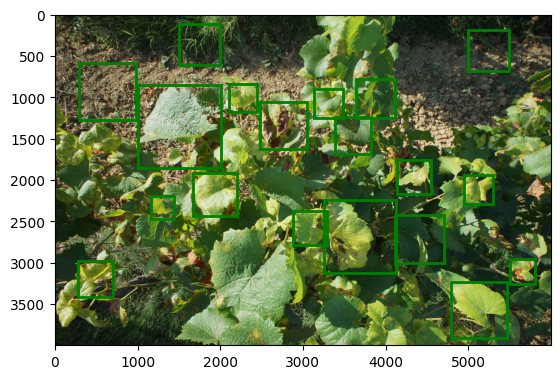

In [26]:
image_path = os.path.join(img_input_folder, 'JBoulent_001.jpg')
label_path = os.path.join(label_input_folder, 'JBoulent_001.txt')
desired_labels = [1]
plot_bboxes(image_path, label_path, desired_labels)

### ATTENZIONE: nel dataset "JBoulent" l'id 0 è riservato per le foglie con flavescenza dorata
### mentre l'id 1 è riservato per foglie sane di vite ma anche per cose che non sono foglie, tipo terra e altre erbe !!!!

**LAUNCH CONVERSION OF BBOXES INTO MASKS**

In [28]:
annotator = Annotator(
    img_input_folder=img_input_folder,
    label_input_folder=label_input_folder,
    mask_output_folder=mask_output_folder,
    desired_labels=[1]
)
annotator.start()
### ATTENZIONE: nel dataset "JBoulent" l'id 0 è riservato per le foglie con flavescenza dorata
### mentre l'id 1 è riservato per foglie sane di vite ma anche per cose che non sono foglie, tipo terra e altre erbe !!!!

Using device: cuda
Tesla T4
Memory Usage:
Allocated: 7.3 GB
Cached:    11.1 GB


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.10 GiB. GPU 

**CHECK A RANDOM MASK GENERATED BY SAM**

In [ ]:
mask_list = sorted([os.path.join(mask_output_folder, f) for f in os.listdir(mask_output_folder)
                  if f.endswith('.tiff') and not f.startswith('.')])
n = len(mask_list)
plot_mask(mask_list[random.randint(0, n)])


**CHECK A RANDOM POLYGON LABEL**

In [ ]:
polygon_list = sorted([os.path.join(polygon_output_folder, f) for f in os.listdir(polygon_output_folder)
                  if f.endswith('.txt') and not f.startswith('.')])
n = len(polygon_list)
print_polygon_label(polygon_list[random.randint(0, n)])